In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
import re
import string
import nltk
from nltk.corpus import stopwords
from sklearn.linear_model import Lasso, LogisticRegression
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
import demoji
import pandas_dedupe
from scipy.sparse import csr_matrix
import sparse_dot_topn.sparse_dot_topn as ct
demoji.download_codes()
nltk.download('stopwords')

... OK (Got response in 0.27 seconds)
Writing emoji data to /Users/cheawu/.demoji/codes.json ...
... OK


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/cheawu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Import Data and Perform Initial Analysis
***

In [2]:
df = pd.read_csv("winemag-data-130k-v2.csv", index_col=0)

In [3]:
df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [4]:
df.shape

(129971, 13)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129971 entries, 0 to 129970
Data columns (total 13 columns):
country                  129908 non-null object
description              129971 non-null object
designation              92506 non-null object
points                   129971 non-null int64
price                    120975 non-null float64
province                 129908 non-null object
region_1                 108724 non-null object
region_2                 50511 non-null object
taster_name              103727 non-null object
taster_twitter_handle    98758 non-null object
title                    129971 non-null object
variety                  129970 non-null object
winery                   129971 non-null object
dtypes: float64(1), int64(1), object(11)
memory usage: 13.9+ MB


In [6]:
def df_detail(df):
    temp = pd.DataFrame(df.dtypes, columns=['dtypes'])
    temp = temp.reset_index()
    temp['Col_Name'] = temp['index']
    temp = temp[['Col_Name','dtypes']]
    temp['Missing_value'] = df.isnull().sum().values
    temp['Missing_rate (%)'] = df.isnull().sum().values / df.shape[0] * 100
    temp['Unique_value'] = df.nunique().values
    temp['Unique_rate (%)'] = df.nunique().values / df.shape[0] * 100
    return temp

In [7]:
df_detail(df)

,Col_Name,dtypes,Missing_value,Missing_rate (%),Unique_value,Unique_rate (%)
0,country,object,63,0.048472,43,0.033084
1,description,object,0,0.000000,119955,92.293666
2,designation,object,37465,28.825661,37979,29.221134
3,points,int64,0,0.000000,21,0.016157
4,price,float64,8996,6.921544,390,0.300067
5,province,object,63,0.048472,425,0.326996
6,region_1,object,21247,16.347493,1229,0.945596
7,region_2,object,79460,61.136715,17,0.013080
8,taster_name,object,26244,20.192197,19,0.014619
9,taster_twitter_handle,object,31213,24.015357,15,0.011541


The columns with relatively high missing value rate are region_2, region_1, taster_name, designation, and twitter_handle.


## Analyzing Features
---

### Numerical features
 - Points (int64)
 - Price (float64)

In [8]:
df.describe()

,points,price
count,129971.000000,120975.000000
mean,88.447138,35.363389
std,3.039730,41.022218
min,80.000000,4.000000
25%,86.000000,17.000000
50%,88.000000,25.000000
75%,91.000000,42.000000
max,100.000000,3300.000000


#### Points
---

The value of points are distributed between 80 and 100, let's take a look at the distribution by plotting a histogram.

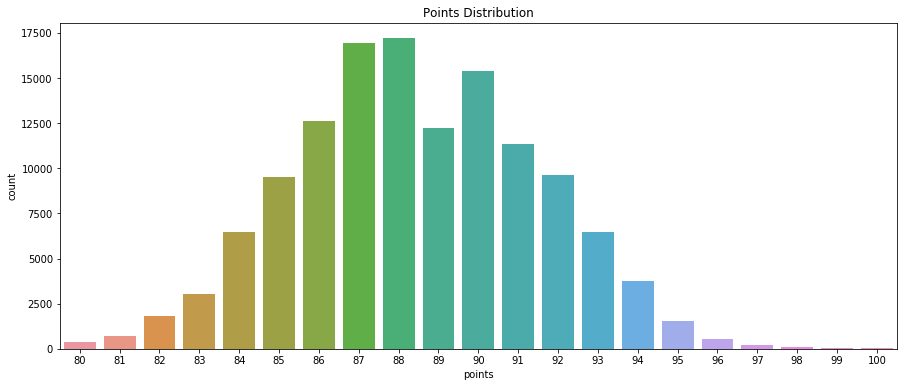

In [9]:
tmp_df = pd.DataFrame({'points': df["points"].value_counts().index, 'count': df["points"].value_counts().values})
plt.figure(figsize = (15,6))
plt.title('Points Distribution')
sns.barplot(x= 'points', y= 'count', data=tmp_df)
locs, labels = plt.xticks()
plt.show()

#### Price
---

- We're worried about wines with missing value in "Price" column since we want to discover the price-performace ratio of different wine types, and we don't want to make prediction for wines which price is missing.
- Drop all the rows which "price" value is NaN.

In [10]:
df = df.dropna(subset=['price'])
df = df.reset_index(drop=True)

The mininum price is 4, the maximum price is 3,300, and the mean value is 35.36. Based on the min, max, and mean, we can know that the distribution of price is not an normal distribution, it might contains some outliers, so we would like to look at the distribution of price by plotting a histogram too.


We're curious about how many wine records which price is more than 1,000. We found that 14 wine's price is greater than 1,000 and 12 of them are from France.

In [11]:
df[(df['price'] > 1000)]

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
1472,France,"A massive wine for Margaux, packed with tannin...",NaN,98,1900.0,Bordeaux,Margaux,NaN,Roger Voss,@vossroger,Château Margaux 2009 Margaux,Bordeaux-style Red Blend,Château Margaux
1480,France,"Such a generous and ripe wine, with a dark cor...",NaN,97,1100.0,Bordeaux,Pessac-Léognan,NaN,Roger Voss,@vossroger,Château La Mission Haut-Brion 2009 Pessac-Léo...,Bordeaux-style Red Blend,Château La Mission Haut-Brion
1485,France,"Solid, very structured, packed with dense and ...",NaN,96,1200.0,Bordeaux,Pessac-Léognan,NaN,Roger Voss,@vossroger,Château Haut-Brion 2009 Pessac-Léognan,Bordeaux-style Red Blend,Château Haut-Brion
1488,France,"The purest Cabernet Sauvignon fruit, with dark...",NaN,96,1300.0,Bordeaux,Pauillac,NaN,Roger Voss,@vossroger,Château Mouton Rothschild 2009 Pauillac,Bordeaux-style Red Blend,Château Mouton Rothschild
14744,France,The wine is a velvet glove in an iron fist. Th...,NaN,96,2500.0,Bordeaux,Pomerol,NaN,Roger Voss,@vossroger,Château Pétrus 2014 Pomerol,Bordeaux-style Red Blend,Château Pétrus
60684,France,This extravagantly perfumed wine has great jui...,NaN,97,2000.0,Bordeaux,Pomerol,NaN,Roger Voss,@vossroger,Château Pétrus 2011 Pomerol,Bordeaux-style Red Blend,Château Pétrus
74674,France,This ripe wine shows plenty of blackberry frui...,NaN,88,3300.0,Bordeaux,Médoc,NaN,Roger Voss,@vossroger,Château les Ormes Sorbet 2013 Médoc,Bordeaux-style Red Blend,Château les Ormes Sorbet
83255,Austria,"Wet earth, rain-wet stones, damp moss, wild sa...",Ried Loibenberg Smaragd,94,1100.0,Wachau,NaN,NaN,Anne Krebiehl MW,@AnneInVino,Emmerich Knoll 2013 Ried Loibenberg Smaragd Gr...,Grüner Veltliner,Emmerich Knoll
91549,France,"A superb wine from a great year, this is power...",NaN,96,2500.0,Burgundy,La Romanée,NaN,Roger Voss,@vossroger,Domaine du Comte Liger-Belair 2010 La Romanée,Pinot Noir,Domaine du Comte Liger-Belair
103975,France,"Almost black in color, this stunning wine is g...",NaN,100,1500.0,Bordeaux,Pauillac,NaN,Roger Voss,@vossroger,Château Lafite Rothschild 2010 Pauillac,Bordeaux-style Red Blend,Château Lafite Rothschild


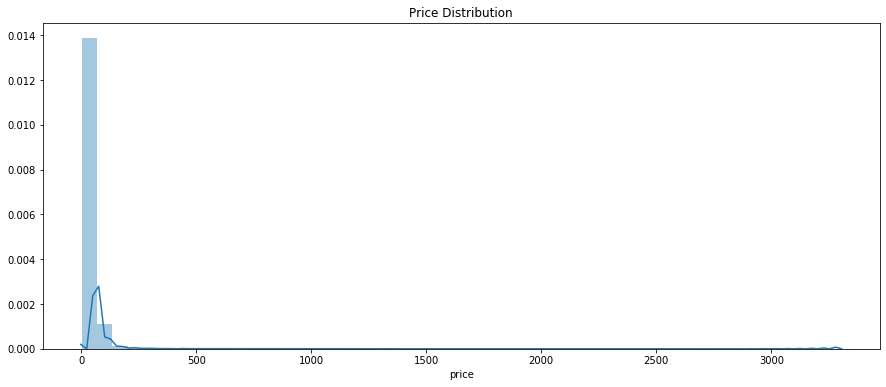

In [12]:
plt.figure(figsize=(15,6))
plt.title("Price Distribution")
ax = sns.distplot(df["price"])

By looking at the histogram, we found that the distribution of price is right skewed. If we want to have a better distribution of price, we'll need to drop the tail or make some transformation to bring it closer to a normal distribution. There are two options that we want to try:
1. Drop the tail: Drop values that greater than 250 dollars. 
2. Use the log transformation: We'll take log(1+x) to avoid running into issues with zero counts.

#### Drop the tail
---

0.37528414961768963 % of price is greater then 250 USD


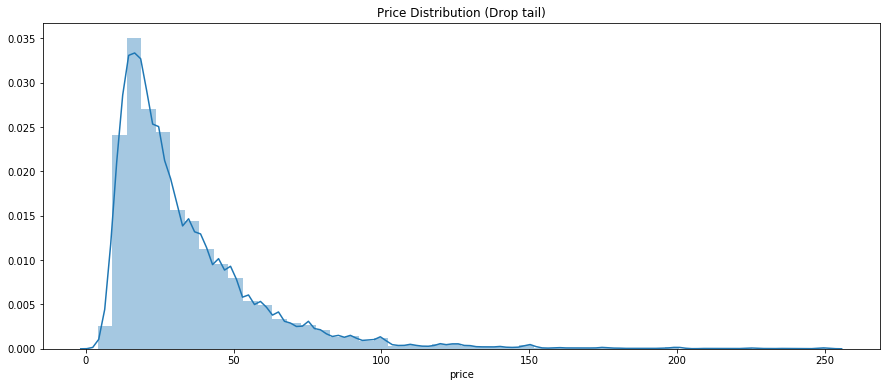

In [13]:
plt.figure(figsize=(15,6))
plt.title("Price Distribution (Drop tail)")
ax = sns.distplot(df[df["price"]<=250]['price'])
per = df[df['price']>250].shape[0]/df.shape[0]*100
print(per, "% of price is greater then 250 USD")

#### Log transformation
---

In [14]:
log = df

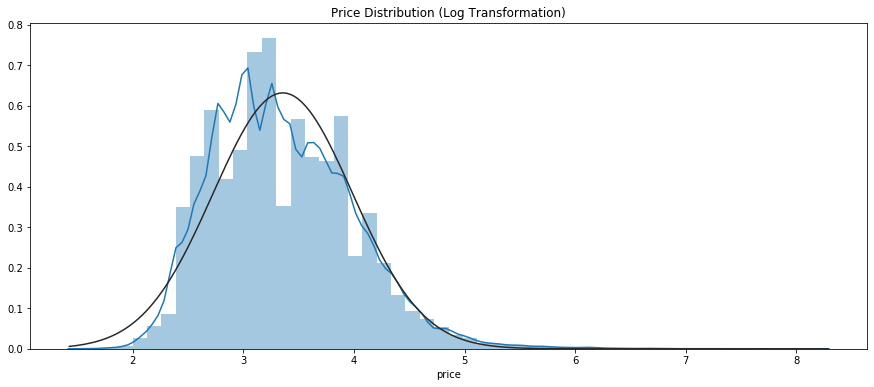

In [15]:
# log transformation
log['price'] = np.log1p(log['price'])

plt.figure(figsize=(15,6))
plt.title("Price Distribution (Log Transformation)")
ax = sns.distplot(log['price'], fit=norm)

### Categorical features

- Country (object)
- Description (object)
- Designation (object)	
- Province (object)	
- Region_1 (object)	
- Region_2 (object)	
- Taster_name (object)	
- Taster_twitter_handle (object)	
- Title (object)	
- Variety (object)	
- Winery (object)

#### Clarification
---
By looking at the missing value rate for each column in the chart above, we can see that the columns with relatively high missing value rate are region_2(61%), region_1(16%), taster_name(20%), designation(28%), and twitter_handle(24%).

- Region_2: According to the dataset description in Kaggle, sometimes there are more specific regions specified within a wine growing area (ie Rutherford inside the Napa Valley), but this value can sometimes be blank. It's reasonable that region_2 has empty value since that record doesn't have a more specific region specified within that wine growing area.

- Taster_name: It's reasonable that some of the wines are not being tasted by a wine taster, so the value in that record might be blank.

- Taster_twitter_handle: It's reasonable that the taster of that wine doesn't have a Twitter account or that wine even not being tasted by a wine taster, so the value in that record might be blank.

- Region_1: We want to find out the relationship between country and wine's price or point, so we think the missing value of region_1 will not have a significant influence on our analysis and prediction.

- Designation: The designation is the vineyard within the winery where the grapes that made the wine are from, same as the feature above, we think designation will not have a significant influence on our analysis and prediction, so we'll just leave these missing value there.




##### But let's still take a look at the count of unique categories for each of our categorical features :)

In [16]:
numerical_features = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

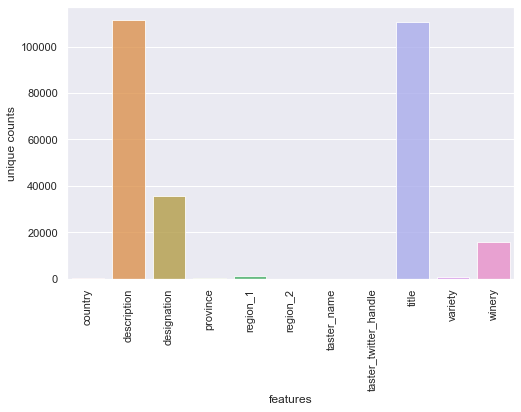

In [17]:
categorical_features_count = df.select_dtypes(exclude=numerical_features).nunique()
sns.set(rc={'figure.figsize':(8,5)})
categorical_features_count_plot = sns.barplot(categorical_features_count.index,\
                                            categorical_features_count.values, alpha=0.8)
categorical_features_count_plot.set(xlabel = 'features', ylabel = 'unique counts')
for item in categorical_features_count_plot.get_xticklabels():
    item.set_rotation(90)

In [18]:
country = pd.DataFrame({'country': df["country"].value_counts().index, 'count': df["country"].value_counts().values})

In [19]:
country.head(20)

,country,count
0,US,54265
1,France,17776
2,Italy,16914
3,Spain,6573
4,Portugal,4875
5,Chile,4416
6,Argentina,3756
7,Austria,2799
8,Australia,2294
9,Germany,2120


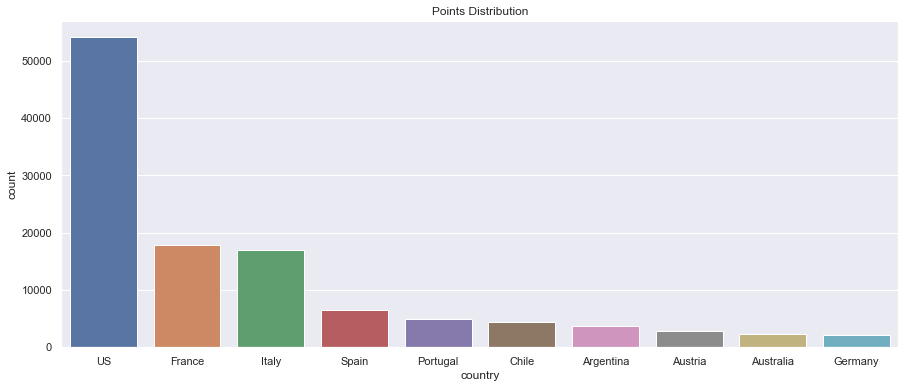

In [20]:
plt.figure(figsize = (15,6))
plt.title('Points Distribution')
sns.barplot(x= 'country', y= 'count', data=country.head(10))
locs, labels = plt.xticks()
plt.show()

### Raw text data

We would also like to take a look at the the "Description" and the "Title" columns. Since these two columns are text data, we will apply regular expression to clean the text data and try to use some natural language processing(NLP) techniques to find out some interesting insights.

In [21]:
df[df.duplicated(['description','title'])].shape[0]

9382

We found that there are a lot of duplicates in the description and title, so we want to get rid of those duplicated records.

In [22]:
df = df.drop_duplicates(['description','title'])
df = df.reset_index(drop=True)

In [23]:
df.shape

(111593, 13)

In [24]:
# Function to clean text
def clean_text(raw_text):
    # convert to string if not in string form
    str_text = raw_text.apply(lambda x: str(x))

    # convert to lower case
    lower_text = str_text.apply(lambda x: x.lower())

    # remove '@'mention - handler
    no_handler_text = lower_text.apply(lambda x: re.sub(r'@\S+', '', x))

    # remove URL Links
    no_handler_URL_text = no_handler_text.apply(lambda x: re.sub('https?://[A-Za-z0-9./]+', '', x))

    # remove html codes
    no_handler_URL_html_text = no_handler_URL_text.apply(lambda x: re.sub('&[A-Za-z]+;','',x))

    # remove emojis
    no_handler_URL_html_emoji_text = no_handler_URL_html_text.apply(lambda x: demoji.replace(x,""))

    # remove punctuations
    no_punc_text = no_handler_URL_html_emoji_text.apply(lambda x: re.sub(r"""
               [),.;:@#?!&$('`’/"-]+  # Accept one or more copies of punctuation
               \ *           # plus zero or more copies of a space,
               """,
               " ",          # and replace it with a single space
               x, flags=re.VERBOSE))
    # remove stopwords
    stopword_set = set(stopwords.words("english"))
    cleaned_text = no_punc_text.apply(lambda x: x.split())
    cleaned_text = cleaned_text.apply(lambda x: [w for w in x if w not in stopword_set])
    cleaned_text = cleaned_text.apply(lambda x: " ".join(x))

    return cleaned_text

Clean text for "Description" column

In [25]:
df['description'] = clean_text(df['description'])

In [26]:
df['description']

0         ripe fruity wine smooth still structured firm ...
1         tart snappy flavors lime flesh rind dominate g...
2         pineapple rind lemon pith orange blossom start...
3         much like regular bottling 2012 comes across r...
4         blackberry raspberry aromas show typical navar...
                                ...                        
111588    notes honeysuckle cantaloupe sweeten delicious...
111589    citation given much decade bottle age prior re...
111590    well drained gravel soil gives wine crisp dry ...
111591    dry style pinot gris crisp acidity also weight...
111592    big rich dry powered intense spiciness rounded...
Name: description, Length: 111593, dtype: object

We would like to discover what is the most common words used for wine description, so we use regex to tokenize sentences to list of words for further analysis.

In [27]:
tokenizer = RegexpTokenizer(r'\w+')
description_token = df['description'].apply(tokenizer.tokenize)
description_token.head(10)

0    [ripe, fruity, wine, smooth, still, structured...
1    [tart, snappy, flavors, lime, flesh, rind, dom...
2    [pineapple, rind, lemon, pith, orange, blossom...
3    [much, like, regular, bottling, 2012, comes, a...
4    [blackberry, raspberry, aromas, show, typical,...
5    [bright, informal, red, opens, aromas, candied...
6    [dry, restrained, wine, offers, spice, profusi...
7    [savory, dried, thyme, notes, accent, sunnier,...
8    [great, depth, flavor, fresh, apple, pear, fru...
9    [soft, supple, plum, envelopes, oaky, structur...
Name: description, dtype: object

In [28]:
all_words = [word for tokens in description_token for word in tokens]
vocab = sorted(list(set(all_words)))

Let's take a look at the top 100 most common words used for wine description.

In [29]:
from collections import Counter
count_all_words = Counter(all_words)
count_all_words.most_common(100)

[('wine', 66707),
 ('flavors', 55626),
 ('fruit', 42627),
 ('aromas', 34293),
 ('palate', 33563),
 ('finish', 30983),
 ('acidity', 28935),
 ('tannins', 25883),
 ('drink', 25692),
 ('cherry', 25586),
 ('black', 24936),
 ('ripe', 22538),
 ('red', 18603),
 ('notes', 16619),
 ('spice', 16210),
 ('oak', 16022),
 ('dry', 15044),
 ('nose', 14962),
 ('rich', 14690),
 ('berry', 14530),
 ('fresh', 14506),
 ('full', 13629),
 ('plum', 13077),
 ('sweet', 11813),
 ('apple', 11652),
 ('blend', 11580),
 ('soft', 11563),
 ('blackberry', 11319),
 ('well', 11317),
 ('white', 11010),
 ('fruits', 10844),
 ('light', 10839),
 ('crisp', 10726),
 ('offers', 10660),
 ('dark', 10575),
 ('texture', 10401),
 ('bodied', 10165),
 ('citrus', 10109),
 ('shows', 9884),
 ('vanilla', 9828),
 ('cabernet', 9698),
 ('bright', 9059),
 ('pepper', 8979),
 ('green', 8485),
 ('raspberry', 8475),
 ('good', 8440),
 ('lemon', 8293),
 ('juicy', 8174),
 ('fruity', 7776),
 ('chocolate', 7717),
 ('firm', 7527),
 ('peach', 7512),
 ('lik

Clean text for "Title" column

In [30]:
df.shape

(111593, 13)

In [31]:
df['title'] = clean_text(df['title'])

In [32]:
df['title']

0               quinta dos avidagos 2011 avidagos red douro
1               rainstorm 2013 pinot gris willamette valley
2         st julian 2013 reserve late harvest riesling l...
3         sweet cheeks 2012 vintner reserve wild child b...
4          tandem 2011 ars vitro tempranillo merlot navarra
                                ...                        
111588    dr h thanisch erben müller burggraef 2013 brau...
111589                      citation 2004 pinot noir oregon
111590     domaine gresser 2013 kritt gewurztraminer alsace
111591          domaine marcel deiss 2012 pinot gris alsace
111592    domaine schoffit 2012 lieu dit harth cuvée car...
Name: title, Length: 111593, dtype: object

---
After cleaning text data for "Description" and "Title" columns, we would like to look at the "Variety" column to see if there's any duplicated value in it.

In [33]:
df['variety'].head(10)

0        Portuguese Red
1            Pinot Gris
2              Riesling
3            Pinot Noir
4    Tempranillo-Merlot
5              Frappato
6        Gewürztraminer
7        Gewürztraminer
8            Pinot Gris
9    Cabernet Sauvignon
Name: variety, dtype: object

In [34]:
df['variety'] = clean_text(df['variety'])

In [35]:
variety = df['variety']

In [36]:
df['variety_count'] = df['variety'].str.split().str.len()

In [37]:
df['variety_count'].value_counts()

1    51247
2    51151
4     7345
3     1847
5        2
0        1
Name: variety_count, dtype: int64

In [63]:
variety_1 = df[(df['variety_count'] == 1)]
variety_2 = df[(df['variety_count'] == 2)]
variety_3 = df[(df['variety_count'] == 3)]
variety_4 = df[(df['variety_count'] == 4)]
variety_1_tfidf = variety_1["variety"]
variety_2_tfidf = variety_2["variety"]
variety_3_tfidf = variety_3["variety"]
variety_4_tfidf = variety_4["variety"]

In [166]:
variety_1 = variety_1.reset_index(drop=True)
variety_2 = variety_2.reset_index(drop=True)
variety_3 = variety_3.reset_index(drop=True)
variety_4 = variety_4.reset_index(drop=True)

In [68]:
df[(df['variety_count'] == 5)]

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,variety_count
871,US,earthy nutty aroma flavor come intense sweetne...,Vin Doux Naturel,87,3.044522,California,Shenandoah Valley (CA),Sierra Foothills,Jim Gordon,@gordone_cellars,terre rouge 2013 vin doux naturel muscat blanc...,muscat blanc à petits grains,Terre Rouge,5
15495,France,lush ripe touch heady rich selection brimming ...,Resplandy,87,2.564949,Languedoc-Roussillon,Muscat de Saint-Jean de Minervois,NaN,Lauren Buzzeo,@laurbuzz,les vignerons de la méditerranée nv resplandy ...,muscat blanc à petits grains,Les Vignerons de la Méditerranée,5


In [69]:
variety_4["variety"].value_counts()

bordeaux style red blend               4958
rhône style red blend                  1283
bordeaux style white blend              635
rhône style white blend                 388
touriga nacional cabernet sauvignon      25
cabernet sauvignon cabernet franc        21
cabernet franc cabernet sauvignon        15
chenin blanc sauvignon blanc              6
loin de l oeil                            6
sauvignon blanc chenin blanc              4
cabernet sauvignon merlot shiraz          2
pinot blanc pinot noir                    1
pinot grigio sauvignon blanc              1
Name: variety, dtype: int64

In [111]:
variety_1_tfidf = variety_1_tfidf.reset_index(drop=True)
variety_2_tfidf = variety_2_tfidf.reset_index(drop=True)
variety_3_tfidf = variety_3_tfidf.reset_index(drop=True)
variety_4_tfidf = variety_4_tfidf.reset_index(drop=True)

In [138]:
ngram_range = (1, 1)

In [139]:
vectorizer = TfidfVectorizer("char", ngram_range=ngram_range, sublinear_tf=True)

In [140]:
tfidf_matrix_1 = vectorizer.fit_transform(variety_1_tfidf.astype('U'))
tfidf_matrix_2 = vectorizer.fit_transform(variety_2_tfidf.astype('U'))
tfidf_matrix_3 = vectorizer.fit_transform(variety_3_tfidf.astype('U'))
tfidf_matrix_4 = vectorizer.fit_transform(variety_4_tfidf.astype('U'))

In [141]:
print(tfidf_matrix_2)

  (0, 148)	0.5678199312935364
  (0, 143)	0.8231527960383804
  (1, 69)	0.9017266063416618
  (1, 135)	0.4323067515266791
  (2, 123)	0.7385596360396541
  (2, 135)	0.6741881517892269
  (3, 100)	0.7850906394599458
  (3, 181)	0.6193808907549323
  (4, 69)	0.9017266063416618
  (4, 135)	0.4323067515266791
  (5, 168)	0.6686684218667583
  (5, 29)	0.7435607181651133
  (6, 168)	0.6686684218667583
  (6, 29)	0.7435607181651133
  (7, 25)	0.3964750054587687
  (7, 181)	0.9180455163261074
  (8, 25)	0.6616189651109766
  (8, 148)	0.7498402129823928
  (9, 123)	0.7385596360396541
  (9, 135)	0.6741881517892269
  (10, 208)	0.8555488103131292
  (10, 25)	0.5177221582777671
  (11, 12)	0.7309690530825415
  (11, 122)	0.682410612047917
  (12, 123)	0.7385596360396541
  :	:
  (51138, 148)	0.7498402129823928
  (51139, 20)	0.49656397467215324
  (51139, 40)	0.8680001261853555
  (51140, 25)	0.6616189651109766
  (51140, 148)	0.7498402129823928
  (51141, 29)	0.35676421968795297
  (51141, 100)	0.9341944613143701
  (51142, 69

In [142]:
def awesome_sparse_dot_top(A, B, ntop, lower_bound=0):
    # force A and B as a CSR matrix.
    # If they have already been CSR, there is no overhead
    A = A.tocsr()
    B = B.tocsr()
    M, _ = A.shape
    _, N = B.shape

    idx_dtype = np.int32

    nnz_max = M * ntop
    indptr = np.zeros(M + 1, dtype=idx_dtype)
    indices = np.zeros(nnz_max, dtype=idx_dtype)
    data = np.zeros(nnz_max, dtype=A.dtype)

    # if A or B are all zeros matrix, return all zero matrix directly
    if len(A.indices) > 0 and len(A.data) > 0 and len(A.indptr) > 0 and \
            len(B.indices) > 0 and len(B.data) > 0 and len(B.indptr) > 0:
        ct.sparse_dot_topn(
            M, N, np.asarray(A.indptr, dtype=idx_dtype),
            np.asarray(A.indices, dtype=idx_dtype),
            A.data,
            np.asarray(B.indptr, dtype=idx_dtype),
            np.asarray(B.indices, dtype=idx_dtype),
            B.data,
            ntop,
            lower_bound,
            indptr, indices, data)

    # N.B. since the indices are grid id here, we still keep the shape as (M,N)
    return csr_matrix((data, indices, indptr), shape=(M, N))

In [157]:
matches = awesome_sparse_dot_top(tfidf_matrix_2, tfidf_matrix_2.transpose(), 10)

In [158]:
matches.count_nonzero()

511154

In [159]:
def get_matches_df(sparse_matrix, name_vector, top=matches.count_nonzero()):
    non_zeros = sparse_matrix.nonzero()
    
    sparserows = non_zeros[0]
    sparsecols = non_zeros[1]
    
    if top:
        nr_matches = top
    else:
        nr_matches = sparsecols.size
    
    left_side = np.empty([nr_matches], dtype=object)
    left_side_idx = np.empty([nr_matches], dtype=object)
    right_side = np.empty([nr_matches], dtype=object)
    right_side_idx = np.empty([nr_matches], dtype=object)
    similairity = np.zeros(nr_matches)
    
    for index in range(0, nr_matches):
        left_side[index] = name_vector[sparserows[index]]
        left_side_idx[index] = sparserows[index]
        right_side[index] = name_vector[sparsecols[index]]
        right_side_idx[index] = sparsecols[index]
        similairity[index] = sparse_matrix.data[index]
    
    return pd.DataFrame({'left_side': left_side,
                         'left_side_idx': left_side_idx,
                         'right_side': right_side,
                         'right_side_idx': right_side_idx,
                         'similarity': similairity})

In [162]:
matches_df = get_matches_df(matches, variety_2_tfidf)

In [163]:
matches_df

,left_side,left_side_idx,right_side,right_side_idx,similarity
0,portuguese red,0,portuguese red,50732,1.0
1,portuguese red,0,portuguese red,50783,1.0
2,portuguese red,0,portuguese red,50784,1.0
3,portuguese red,0,portuguese red,50798,1.0
4,portuguese red,0,portuguese red,50838,1.0
...,...,...,...,...,...
511149,pinot gris,51150,pinot gris,51119,1.0
511150,pinot gris,51150,pinot gris,51142,1.0
511151,pinot gris,51150,pinot gris,51144,1.0
511152,pinot gris,51150,pinot gris,51148,1.0


In [164]:
unique_df = matches_df[(matches_df['similarity'] < 0.99999)].sort_values(["left_side_idx", "similarity"], ascending=(True, False))

In [165]:
unique_df

,left_side,left_side_idx,right_side,right_side_idx,similarity
37,tempranillo merlot,3,cabernet merlot,39418,0.733427
38,tempranillo merlot,3,cabernet merlot,39874,0.733427
39,tempranillo merlot,3,merlot cabernet,42767,0.733427
2915,garnacha tintorera,291,garnacha blend,25704,0.572904
2918,garnacha tintorera,291,garnacha blend,40141,0.572904
...,...,...,...,...,...
510271,pinot chardonnay,51062,chardonnay sauvignon,39402,0.910557
510699,touriga franca,51105,touriga nacional,48956,0.397519
510700,touriga franca,51105,touriga nacional,49150,0.397519
510701,touriga franca,51105,touriga nacional,49331,0.397519


In [169]:
variety_1.to_csv("variety_1")

In [170]:
variety_2.to_csv("variety_2")

In [171]:
variety_3.to_csv("variety_3")

In [172]:
variety_4.to_csv("variety_4")